# Finite Markov Decision Processes

Finite because the state and actions are discrete. Markovian because state depends only on the previous state + action pair. 

In [76]:
from enum import IntEnum

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import gymnasium as gym
from gymnasium import spaces

In [604]:
class Action(IntEnum):
    N = 0
    S = 1
    W = 2
    E = 3

class WindyGridworld(gym.Env):
    def __init__(self):
        self.dims = [7, 10]
        
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.dims[0]),
                spaces.Discrete(self.dims[1])
                ))
        self.start = [3, 0]
        self.goal = [3, 7]
        self.wind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        self.reset()

    def step(self, action):
        """
        Returns: observation, reward, terminated, truncated, info
        """
        self.t += 1
        i, j = self.S

        if action == Action.S:
            i  = max(min(i + 1 - WIND[j], self.dims[0] - 1), 0)
        elif action == Action.N:
            i = max(i - 1 - WIND[j], 0)
        elif action in [Action.W, Action.E]:
            i = max(i - WIND[j], 0)
            if action == Action.E:
                j = min(j + 1, self.dims[1] - 1)
            elif action == Action.W:
                j = max(j - 1, 0)

        self.S = [i, j]
        return self.S, -1, self.S == self.goal

    def reset(self):
        self.S = self.start
        self.t = 0
        return self.S

In [605]:
env = WindyGridworld()
observation = env.reset()

In [633]:
## visualize optimal move for windy grid world

for i in range(0, env.dims[0]):
    print('\n')
    for j in range(0, env.dims[1]):
        if [i, j] == GOAL:
            print(' * ', end="")
            continue
        bestAction = np.argmax(algo.q[i, j, :])
        if bestAction == Action.N:
            print(' ↑ ', end="")
        elif bestAction == Action.S:
            print(' ↓ ', end="")
        elif bestAction == Action.W:
            print(' ← ', end="")
        elif bestAction == Action.E:
            print(' → ', end="")




 ↑  ↑  →  →  →  →  →  →  →  ↓ 

 →  ↑  →  →  →  →  →  →  →  ↓ 

 →  →  →  →  →  →  →  ↑  →  ↓ 

 →  →  →  →  →  →  →  *  →  ↓ 

 →  →  →  →  →  →  ↑  ↓  ←  ← 

 ←  →  ↑  →  →  ↑  ↑  ↓  →  ↓ 

 ↓  →  ↑  →  ↑  ↑  ↑  ↑  ←  ← 

In [711]:
env = gym.make("CartPole-v1")
observation, _ = env.reset()

env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

In [638]:
def _discretize(observation, bins):
    return [np.digitize(o, b) - 1 for o, b in zip(observation, bins)]

In [640]:
_discretize(observation, bins)

[0, 0, 2, 1]

In [658]:
def one_of_best(values):
    return np.random.choice(np.where(values==np.max(values))[0])

class QLearning:
    def __init__(self, alpha, eps, s_dims, a_dim, sarsa=False, gamma=1):
        self.alpha = alpha
        self.eps = eps
        self.a_dim = a_dim
        self.q = np.zeros(s_dims + [a_dim])
        self.sarsa = sarsa
        self.gamma = gamma

    def init_episode(self, init_s, init_a):
        self.s = init_s
        self.a = init_a

    def sample(self, state, return_max=False):
        if return_max or (np.random.binomial(1, self.eps) == 0):
            return one_of_best(self.q[*state])
        return np.random.choice(self.a_dim)

    def update(self, reward, n_state, n_action):
        action = n_action if self.sarsa else self.sample(n_state, return_max=True)
        self.q[*self.s, self.a] += self.alpha*(reward + self.gamma*self.q[*n_state, action] - self.q[*self.s, self.a])
        self.s = n_state
        self.a = n_action

In [704]:
dims = [3, 3, 9, 5]
bins = [
    np.linspace(-2.4, 2.4, dims[0]), 
    np.linspace(-3, 3, dims[1]),
    np.linspace(-.2095, .2095, dims[2]),
    np.linspace(-3, 3, dims[3])
    ]

In [708]:
np.random.seed(seed=123456789)

algo = QLearning(0.3, 0.05, dims, 2)
ts = []

for i in range(3000):
    observation, info = env.reset()
    d_obs = _discretize(observation, bins)
    action = algo.sample(d_obs)
    algo.init_episode(d_obs, action)
    t = 0
    while True:
        observation, reward, terminated, truncated, info = env.step(action)
        d_obs = _discretize(observation, bins)
        action = algo.sample(d_obs)
        algo.update(reward, d_obs, action)
        t += 1
        if terminated:
            break
    ts.append(t)    

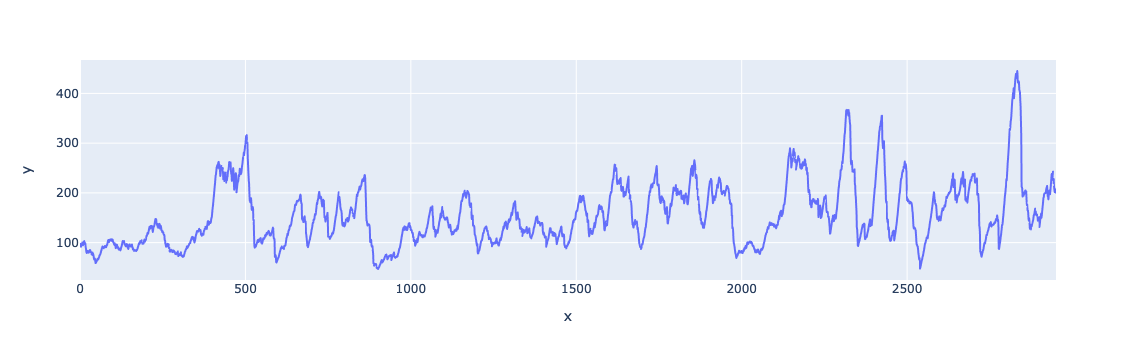

In [721]:
px.line(y=np.convolve(ts, np.arange(50)*2/49/50, 'valid'))

In [719]:
## evaluate cart pole with entirely greedy policy

algo.eps = 0
observation, info = env.reset()
t = 0
while True:
    d_obs = _discretize(observation, bins)
    action = algo.sample(d_obs)
    observation, reward, terminated, truncated, info = env.step(action)
    t += 1
    if terminated:
        break
print(t)

656
